# Super Resolution Convolutional Neural Networks (SRCNN)

This notebook aims to reproduce the work of Dong et. al (2015) with the DIV2K dataset.

Link to their arXiv paper:

[Image Super-Resolution Using Deep Convolutional Networks](https://arxiv.org/abs/1501.00092)

Link to DIV2K dataset:

[DIV2K dataset: DIVerse 2K resolution high quality images](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

# 1 Import Libraries

In [1]:
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader

import torch
import cv2
import numpy as np
import torchvision.transforms as transforms

from torch.optim import SGD

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from tqdm import tqdm
from datetime import datetime

cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

False

# 2 Model Architecture

In [2]:
class SRCNN(torch.nn.Module):
    def __init__(self, num_channels=1, num_filters=(64, 32), kernel_sizes=(9, 1, 5)):
        super(SRCNN, self).__init__()

        self.convs = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels, num_filters[0], kernel_size=kernel_sizes[0])
        )

        for i in range(len(num_filters) - 1):
            self.convs.append(torch.nn.Conv2d(num_filters[i], num_filters[i + 1], kernel_size=kernel_sizes[i + 1]))

        self.convs.append(torch.nn.Conv2d(num_filters[-1], num_channels, kernel_size=kernel_sizes[-1]))

        self.relu = torch.nn.ReLU(inplace=False)

        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)
                torch.nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x)
            x = self.relu(x)

        x = self.convs[-1](x)  # Last layer does not have ReLU activation
        x = x.clamp(0.0, 1.0)  # Clamp output to [0, 1] range
        
        # Output is shrinked by sum(kernel_sizes) - len(kernel_sizes) due to zero padding
        return self.convs(x)

# 3 Dataset Definition

The following configurations are used:

- Sub-images size: 33 x 33
- Stride: 14
- Scaling factor: 3

In [3]:
from collections import OrderedDict
from PIL import Image

class SRCNNTrainingDataset(Dataset):
    def __init__(self, img_dir, sub_img_size=33, stride=14, scale=3, subset=None, cache_size=64, convert_YCbCr=False):
        super(SRCNNTrainingDataset, self).__init__()

        self.img_dir = img_dir
        self.sub_img_size = sub_img_size
        self.stride = stride
        self.scale = scale
        self.cache_size = cache_size
        self.cache = OrderedDict()
        self.convert_YCbCr = convert_YCbCr

        imgs_path = glob(os.path.join(img_dir, '*.png'))

        if subset is not None:
            if isinstance(subset, int):
                imgs_path = imgs_path[:subset]
            elif isinstance(subset, float):
                imgs_path = imgs_path[:int(len(imgs_path) * subset)]

        img_patches_count = []
        sub_imgs_count = 0

        bar = tqdm(imgs_path, desc='Calculating image patches count')
        
        for path in bar:
            img = Image.open(path).convert('RGB')

            # Ensure the image is divisible by the scale factor
            w, h = img.size
            img = img.crop((0, 0, w - (w % scale), h - (h % scale)))

            w, h = img.size

            h_count = (h - sub_img_size) // stride + 1
            w_count = (w - sub_img_size) // stride + 1
            sub_imgs_count += h_count * w_count

            img_patches_count.append((sub_imgs_count, h_count, w_count))

        self.img_patches_count = img_patches_count
        
        self.transform_hr = transforms.ToTensor()

        # Create low-resolutioin image by downscaling and blurring
        self.transform_lr = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(scale * 2 + 1, scale * 2 + 1), sigma=1),
            transforms.Resize((sub_img_size // scale, sub_img_size // scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize((sub_img_size, sub_img_size), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return self.img_patches_count[-1][0]
    
    def __getitem__(self, idx):
        img_idx = 0

        while idx >= self.img_patches_count[img_idx][0]:
            img_idx += 1

        w_count = self.img_patches_count[img_idx][2]
        excess = idx - self.img_patches_count[img_idx - 1][0] if img_idx > 0 else idx
        idx_h = excess // w_count
        idx_w = excess % w_count

        # Read image from cache or disk
        path = os.path.join(self.img_dir, str.zfill(str(img_idx + 1), 4) + '.png')
        if path in self.cache:
            img = self.cache[path]
        else:
            img = Image.open(path).convert('RGB')
            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)
        self.cache[path] = img

        patch = img.crop((
            idx_w * self.stride, idx_h * self.stride,
            idx_w * self.stride + self.sub_img_size, idx_h * self.stride + self.sub_img_size
        ))

        if self.convert_YCbCr:
            patch = patch.convert('YCbCr')

        hr = self.transform_hr(patch)
        lr = self.transform_lr(patch)

        return lr, hr
    
class SRCNNValidationDataset(Dataset):
    def __init__(self, img_dir, scale=3, subset=None, convert_YCbCr=False):
        super(SRCNNValidationDataset, self).__init__()

        self.img_dir = img_dir
        self.scale = scale
        self.imgs_path = glob(os.path.join(img_dir, '*.png'))
        self.convert_YCbCr = convert_YCbCr

        if subset is not None:
            if isinstance(subset, int):
                self.imgs_path = self.imgs_path[:subset]
            elif isinstance(subset, float):
                self.imgs_path = self.imgs_path[:int(len(self.imgs_path) * subset)]

        self.transform_hr = transforms.ToTensor()

    def __len__(self):
        return len(self.imgs_path)
    
    def __getitem__(self, idx):
        img = Image.open(self.imgs_path[idx]).convert('RGB')

        if self.convert_YCbCr:
            img = img.convert('YCbCr')

        w, h = img.size

        # Create low-resolutioin image by downscaling and blurring
        transform_lr = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(self.scale * 2 + 1, self.scale * 2 + 1), sigma=1),
            transforms.Resize((h // self.scale, w // self.scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize((h, w), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

        hr = self.transform_hr(img)
        lr = transform_lr(img)
        
        return lr, hr

Calculating image patches count:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating image patches count: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


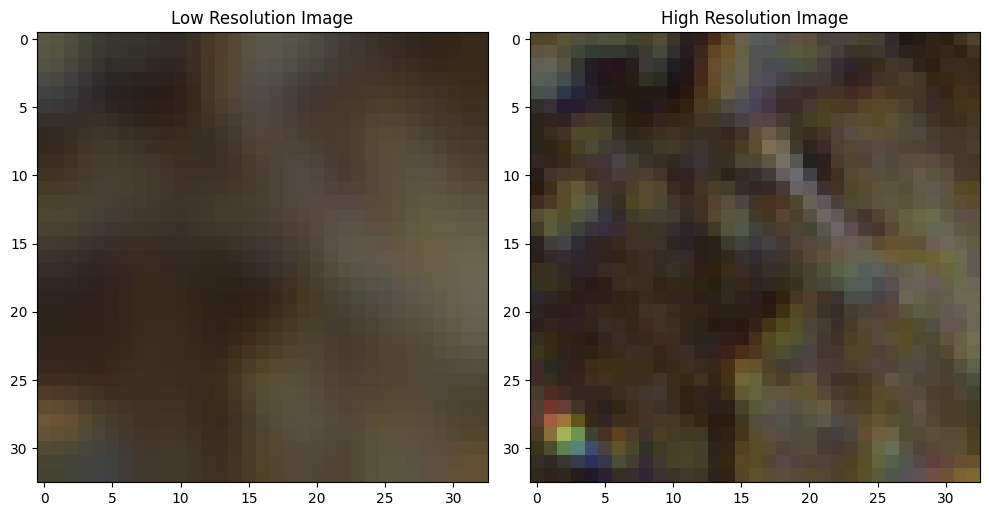

In [4]:
sample_dataset = SRCNNTrainingDataset(
    img_dir=r'../data/DIV2K_train_HR',
    sub_img_size=33,
    stride=14,
    scale=3,
    subset=1
)
idx = np.random.randint(0, len(sample_dataset))

sample_lr, sample_hr = sample_dataset[idx]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow(sample_hr.permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')

plt.tight_layout()
plt.show()

# 4 Training

In [6]:
batch_size = 128

train_dataset = SRCNNTrainingDataset(img_dir=r'../data/DIV2K_train_HR', sub_img_size=33, stride=14, scale=3, subset=1)
set5_val_dataset = SRCNNValidationDataset(img_dir=r'../data/Set5', scale=3)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_set5_loader = DataLoader(set5_val_dataset, batch_size=1, shuffle=False)

srcnn_9_1_5 = SRCNN(num_channels=3, num_filters=(64, 32), kernel_sizes=(9, 1, 5)).to(cuda_device)

srcnn_9_1_5_optim = SGD(
    [
        {'params': srcnn_9_1_5.convs[0].parameters(), 'lr': 1e-4},
        {'params': srcnn_9_1_5.convs[1].parameters(), 'lr': 1e-4},
        {'params': srcnn_9_1_5.convs[2].parameters(), 'lr': 1e-5},
    ],
    momentum=0.9
)

mse_loss = torch.nn.MSELoss(reduction='mean')

Calculating image patches count:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating image patches count: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


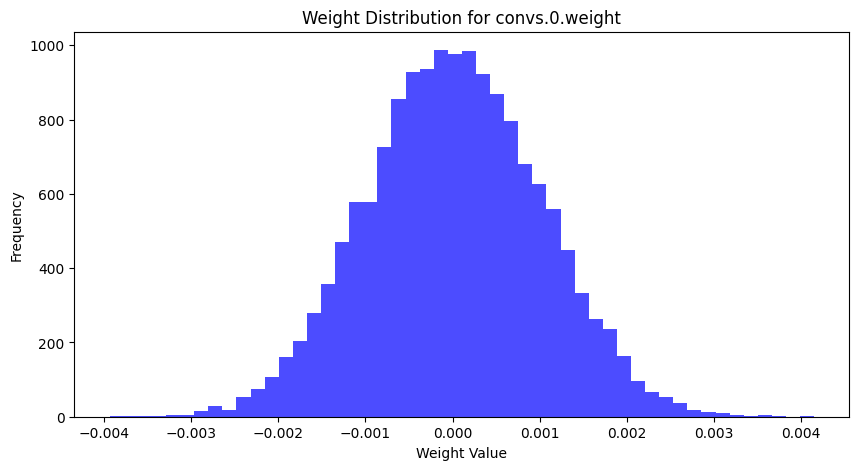

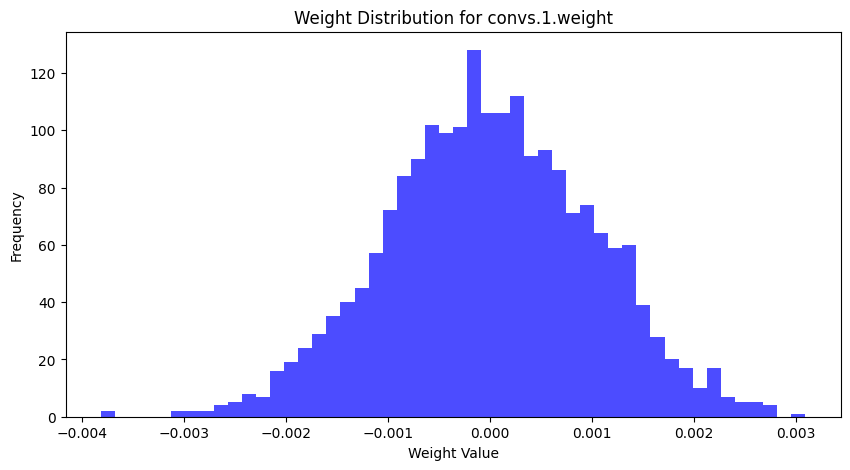

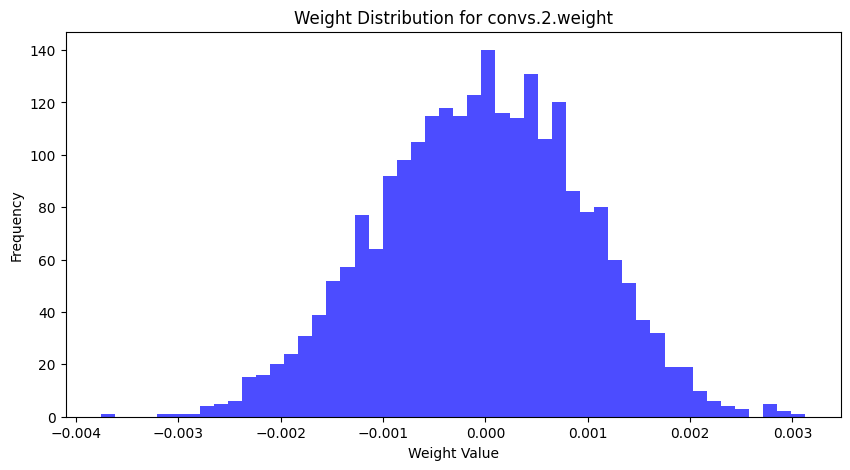

In [11]:
import matplotlib.pyplot as plt

# Access the model's weights
weights = srcnn_9_1_5.state_dict()

# Iterate through the layers and plot the weight distributions
for name, param in weights.items():
    if "weight" in name:  # Only check weights, not biases
        plt.figure(figsize=(10, 5))
        plt.hist(param.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue')
        plt.title(f"Weight Distribution for {name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()

In [12]:
epochs = 1
writer = SummaryWriter(log_dir='../runs/srcnn_9_1_5')

for epoch in range(epochs):
    srcnn_9_1_5.train()
    train_loss = 0.0

    bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

    for lr, hr in bar:
        lr = lr.to(cuda_device, non_blocking=True)
        hr = hr.to(cuda_device, non_blocking=True)

        srcnn_9_1_5_optim.zero_grad()

        sr = srcnn_9_1_5(lr)

        _, _, h, w = sr.shape
        hr_cropped = transforms.CenterCrop([h, w])(hr)

        loss = mse_loss(sr, hr_cropped)

        loss.backward()
        srcnn_9_1_5_optim.step()

        train_loss += loss.item()

        bar.set_postfix({'loss': loss.item()})

    train_loss /= len(train_loader)
    writer.add_scalar('Loss/train', train_loss, epoch)

    print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {train_loss:.6f}")

writer.close()

Epoch 1/1:   0%|          | 0/111 [00:00<?, ?batch/s]c:\Users\yeapj\Downloads\single-image-super-resolution\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/1: 100%|██████████| 111/111 [01:39<00:00,  1.12batch/s, loss=0.107] 

Epoch 1/1 - Average Loss: 0.109063


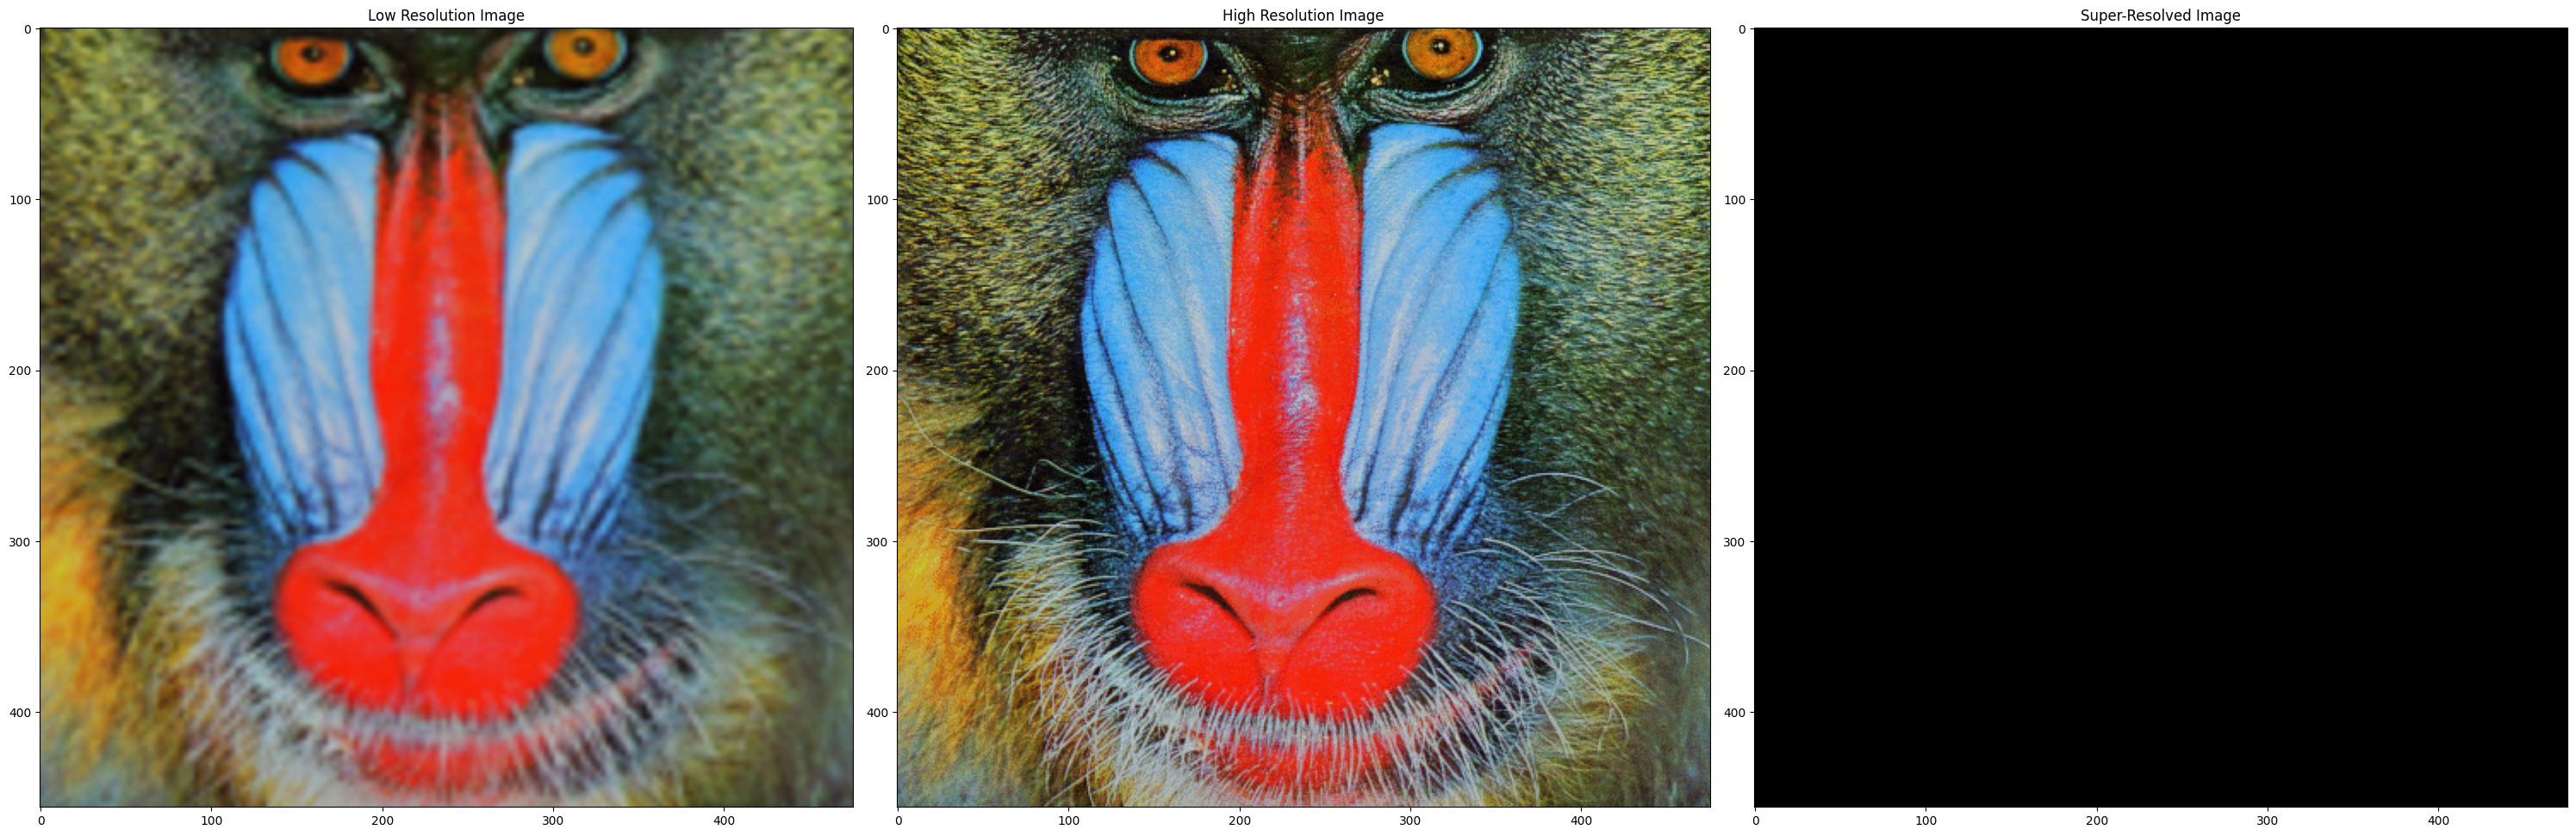

In [13]:
set14_dataset = SRCNNValidationDataset(
    img_dir=r'../data/Set14',
    scale=3,
    subset=1
)
idx = np.random.randint(0, len(set14_dataset))

sample_lr, sample_hr = set14_dataset[idx]

srcnn_9_1_5.eval()
with torch.no_grad():
    sample_lr = sample_lr.to(cuda_device).unsqueeze(0)

    sr = srcnn_9_1_5(sample_lr).squeeze(0).cpu()
    sr = sr.clamp(0.0, 1.0).squeeze(0).cpu()

sample_lr = transforms.CenterCrop((sr.shape[1], sr.shape[2]))(sample_lr).squeeze(0).cpu()
sample_hr = transforms.CenterCrop((sr.shape[1], sr.shape[2]))(sample_hr).squeeze(0).cpu()

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow(sample_hr.permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')
axes[2].imshow(sr.permute(1, 2, 0).cpu().numpy())
axes[2].set_title('Super-Resolved Image')

plt.tight_layout()
plt.show()

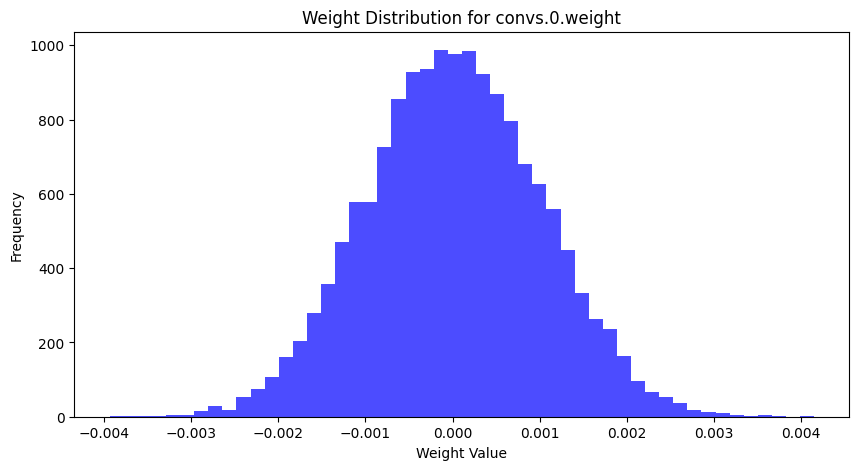

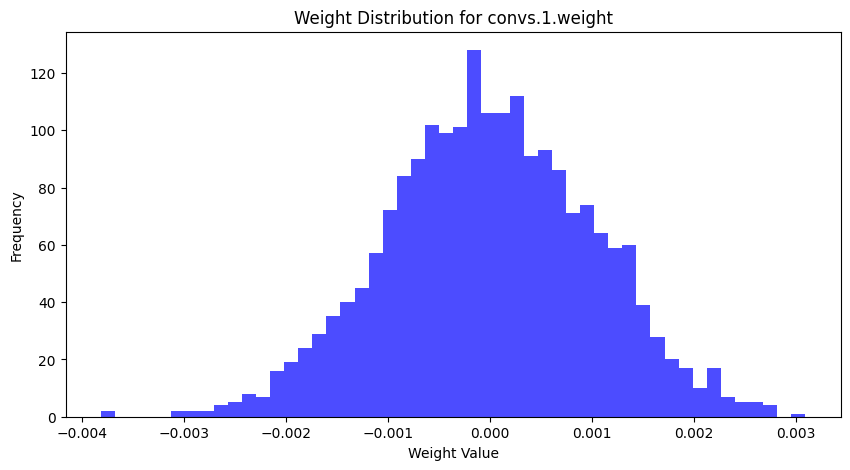

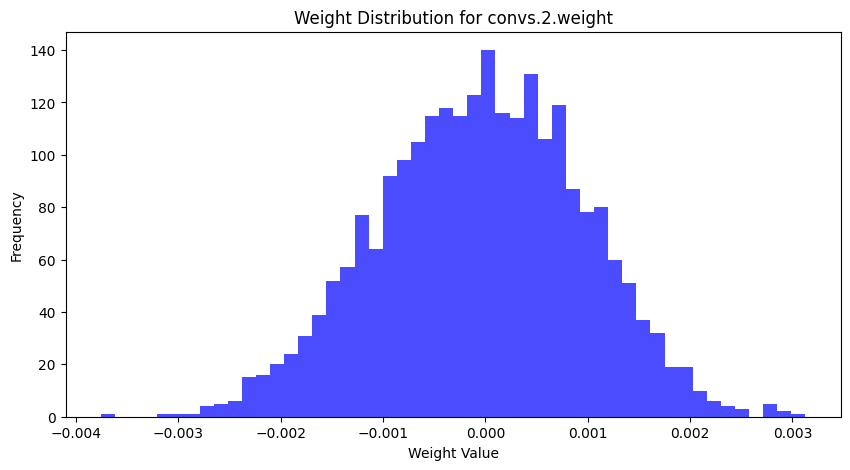

In [14]:
import matplotlib.pyplot as plt

# Access the model's weights
weights = srcnn_9_1_5.state_dict()

# Iterate through the layers and plot the weight distributions
for name, param in weights.items():
    if "weight" in name:  # Only check weights, not biases
        plt.figure(figsize=(10, 5))
        plt.hist(param.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue')
        plt.title(f"Weight Distribution for {name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()

In [15]:
sr.min(), sr.max(), sr.mean(), sr.std()

(tensor(0.0015), tensor(0.0025), tensor(0.0018), tensor(0.0004))

In [ ]:
torch.load(r'C:\Users\yeapj\Downloads\single-image-super-resolution\models\srcnn\srccn_9_1_5_best.pt', weights_only=False)